# Final Project 1 #
## Fundamentals of Neural Networks ##
### Multi-layer Perceptron ###

In [1]:
import os
import struct
import numpy as np

In [2]:
# function to load the MINST dataset

def load_minst(path, kind='train'):
    """ function of loading MINST data from 'path' """
    
    #print(path)
    
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    #print(labels_path)
    #print(images_path)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack("<IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 28*28)
        images = images / 255.0
    
    return images, labels

In [3]:
# load the MINST dataset, both training and testing datasets

path = r'data_mlp/'

X_train, y_train = load_minst(path, kind='train')
print('Rows: {}, columns: {}'.format(X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_minst(path, kind='t10k')
print('Rows: {}, columns: {}'.format(X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


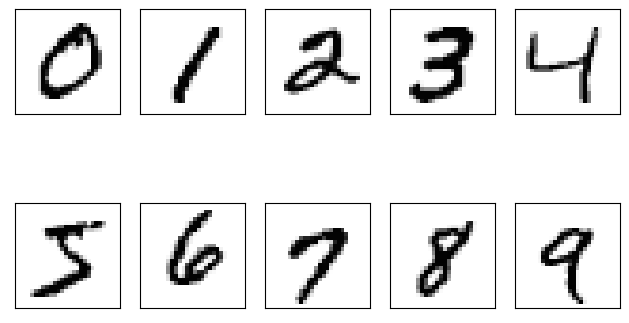

In [4]:
# visualize some digits between 0 and 9 in MNIST dataset

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(10):
    img = X_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

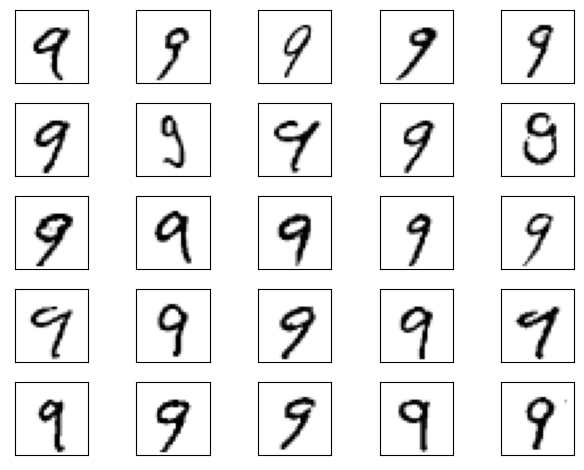

In [5]:
# Visualize the same digit with multiple examples from the training dataset

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(25):
    img = X_train[y_train == 9][i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

# Implementation of the multilayer perceptron #

In [6]:
import numpy as np
import sys
from numpy import exp
import random

In [7]:
from IPython.display import Image
%matplotlib inline

# Forward propagation / Forward pass #

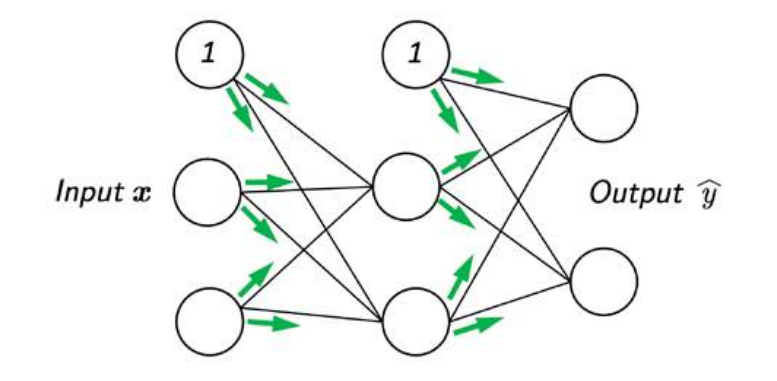

In [8]:
# Extracted from Python Machine Learning, Third edition, by Sebastian Raschka and Vahid Mirjalili

Image(filename='forward_propagation.png', width=600)

# Error backpropagation #

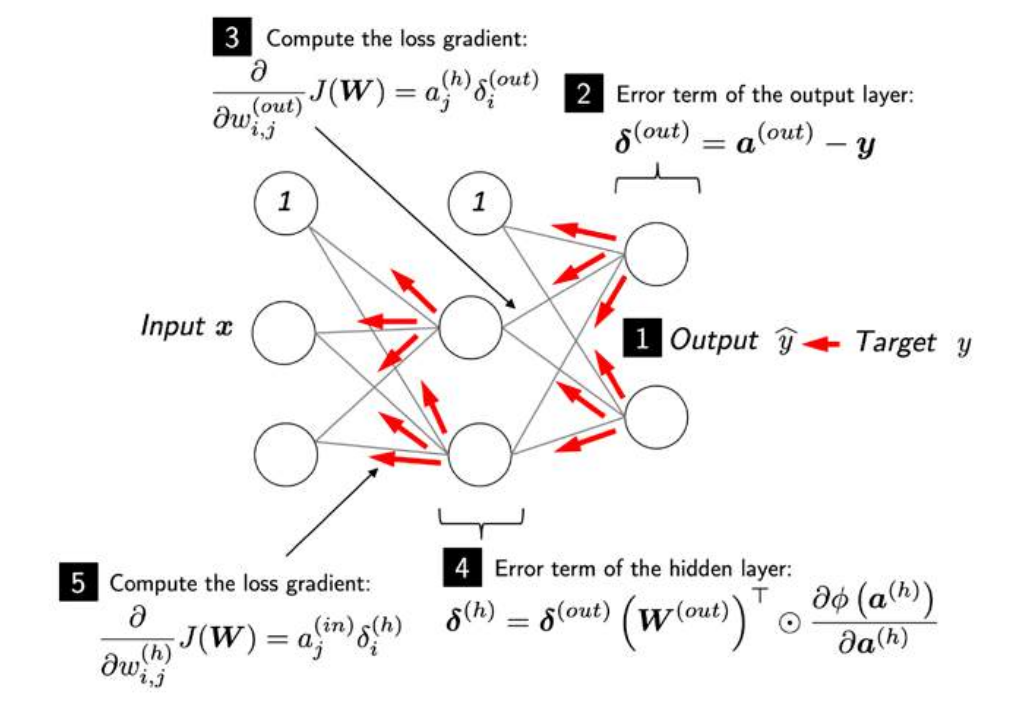

In [9]:
# Extracted from Python Machine Learning, Third edition, by Sebastian Raschka and Vahid Mirjalili

Image(filename='Neural_Network_MLP_error_backpropagation.png', width=600) 

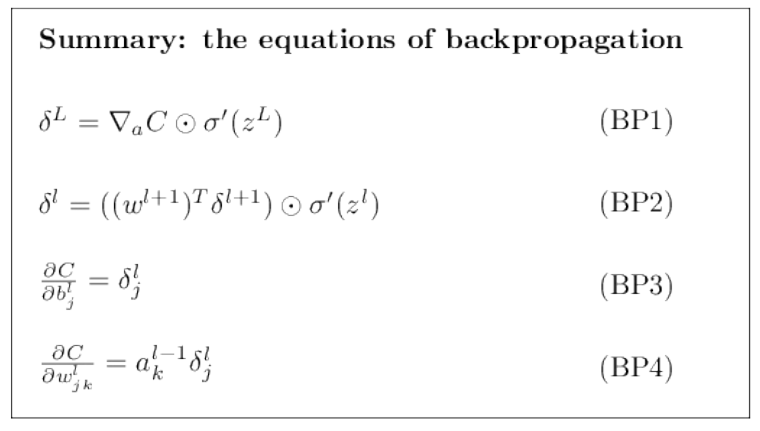

In [10]:
# Extracted from the website of http://neuralnetworksanddeeplearning.com/
# by Michael Nielsen

Image(filename='summary_equations_of_backpropagation.png', width=600) 

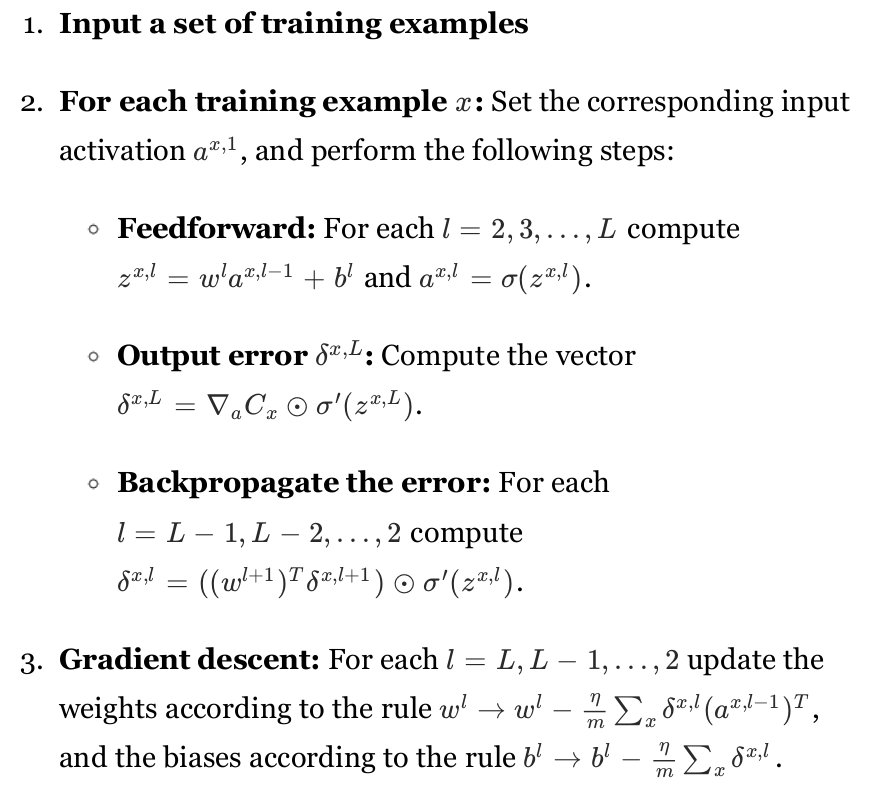

In [11]:
# Extracted from the website of http://neuralnetworksanddeeplearning.com/
# by Michael Nielsen

Image(filename='algorithm_minibatch_GD.png', width=600) 

In [12]:
class NNMLP(object):
    """ 
    Feedforward neural network (NN) multilayer perceptron (MLP)
    
    Hyperparameters:
    ----------------
    n_hidden : number of hidden neurons (integer, default: 30)
    epochs: number of passes over the training dataset (int, default: 100)
    lr: learning rate (float, default: 0.001)
    shuffle: shuffle the training dataset in every epoch (boolean, default: True)
    minibatch_size: the size of training exmples in a mini-batch (int, default: 100)
    seed: random seed for initialization of weights, biases and shuffling (int, default: None)
    acfun: activation funtion for the hidden layer (default: sigmoid)
    """
    
    def __init__(self, n_hidden=30, epochs=100, lr=0.001, shuffle=True, minibatch_size=100, seed=None, acfun="sigmoid"):
        """ constructor of the object of class NNMLP """
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.lr = lr
        self.epochs = epochs
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.activationFunction = acfun
    
    def onehot(self, y, n_classes):
        """ 
        Encode the labels into one-hot encoding represention of each sample in training, validation, and testing datasets
        
        Parameters:
        -----------
        y: array of target values (array, the shape is [number of samples])
        
        Return:
        -------
        onehot: one-hot representation (array, the shape is [number of samples, size of labels])
        """
        
        onehot = np.zeros((len(y), n_classes))
        for idx, val in enumerate(y):
            onehot[idx, val] = 1.0
        
        return onehot
    
    def sigmoid(self, z):
        """ compute the sigmoid activation function """
        return 1.0 / (1.0 + np.exp(-z))
    
    def relu(self, z):
        """ compute the ReLU (rectified linear unit) activation function """
        return np.maximum(0.0, z)

    def reluDerivative(self, a_h):
        """ compute the derivative of the ReLU activation function """
        a_h[a_h <= 0.0] = 0.0
        a_h[a_h > 0.0] = 1.0
        return a_h
    
    def softmax(self, x):
        """ compute the softmax activation function of the output layer """
        x_softmax = np.zeros((x.shape[0], x.shape[1]))
        for i in range(len(x)):
            x_softmax[i] = np.exp(x[i])/np.sum(np.exp(x[i]),axis=0)
        return x_softmax
    
    def forwardPass(self, X):
        """ 
        compute the forward pass / forward propagation 
        
        Parameters:
        -----------
        X: the input features for the input layer
        
        Return:
        -------
        z_h: the input of the hidden layer (input_features*weights + biases)
        a_h: the output of the hidden layer after applying the activation function (activation_function(z_h))
        z_out: the input of the output layer (output_from_hidden_layer*weights + biases)
        a_out: the output of the output layer after applying the activation function (activation_function(z_output))
        """
        
        # step 1: compute the input of the hidden layer
        # self.w_h: weights between the input layer and hidden layer
        # self.b_h: biases for the neurons in the hidden layer
        # z_h: the input of the hidden layer
        z_h = np.dot(X, self.w_h) + self.b_h
        
        # step 2: activation of the hidden layer
        # two activation functions can be selected: sigmoid or ReLU
        # a_h: the output of the hidden layer after applying the activation function
        if self.activationFunction == "sigmoid":
            a_h = self.sigmoid(z_h)
        elif self.activationFunction == "relu":
            a_h = self.relu(z_h)
        
        # step 3: compute the input fot the output layer
        # self.w_out: weights between the hidden layer and output layer
        # self.b_out: biases for the neurons in the output layer
        # z_out: the input of the output layer
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        # step 4: activation of output layer
        # a_out: the output of the output layer after applying the activation function
        # the activation function selected is softmax (this is because we will apply the Cross Entropy Loss function afterward)
        a_out = self.softmax(z_out)

        return z_h, a_h, z_out, a_out
    
    def crossEntropyLoss(self, y_enc, output):
        """
        compute the lost with the Cross-Entropy loss costfunction
        
        
        Parameter:
        ----------
        y_enc: one-hot encoded class labels
        output: output from the output layer in the forward propagation steps
        
        Return:
        -------
        loss: computed lost with the Cross-Entropy loss cost function (float)
        """
        
        loss_sum = -np.sum(y_enc*np.log(output))
        loss = loss_sum/float(y_enc.shape[0])
        
        return loss
    
    def predict(self, X):
        """
        prediction of the class label
        
        Parameter:
        ----------
        X: input layer with the original features
        
        Return:
        -------
        y_pred: predicted class labels
        """
        
        z_h, a_h, z_out, a_out = self.forwardPass(X)
        y_pred = np.argmax(z_out, axis=1)
        
        return y_pred
    
    def train(self, X_train, y_train, X_valid, y_valid):
        """
        Learn the weights and biases from the training data during training phase
        
        Parameters:
        -----------
        X_train: input features in the training data
        y_train: target class labels in the training data
        X_valid: input features in the validation data
        y_valid: target class labels in the validation data
        
        Return:
        -------
        train_acc_list: the list of train accuracy for every epoch
        valid_acc_list: the list of validation accuracy for every epoch
        train_losses: the list of train loss for every epoch
        valid_losses: the list of validation loss for every epoch
        """
        
        n_output = len(np.unique(y_train))   # number of class labels, for MINST, the number of class labels is 10 (0 to 9)
        n_features = X_train.shape[1]   # number of input features in the training dataset
        
        ##############################
        #    Weight initialization   #
        ##############################
        
        # weight initialization: between input layer and hidden label
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        # wight initialization: between hidden layer and output layer
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
        
        #encode the one-hot representation of the training dataset target
        y_train_enc = self.onehot(y_train, n_output)
        y_valid_enc = self.onehot(y_valid, n_output)
        
        train_acc_list = []   # to store the train accuracies for every epoch
        valid_acc_list = []   # to store the validation accuracies for every epoch
        
        train_losses = []   # to store the train losses for every epoch
        valid_losses = []   # to store the validation losses for every epoch
        
        ##################################
        #    trainining and validation   #
        ##################################
        for i in range(self.epochs):
            
            # define indices for the training samples dataset
            indices = np.arange(len(X_train))
            
            # shuffle the indices of the the training samples dataset
            if self.shuffle:
                self.random.shuffle(indices)
            
            # the weights and biases are updated in the following loops with selected mini-batch training samples
            for start_idx in range(0, len(indices)-self.minibatch_size+1, self.minibatch_size):
            
                # to be used to select the batch indices from the training samples
                batch_idx = indices[start_idx : start_idx+self.minibatch_size]
                
                ##########################################
                #   forward pass / forward propagation   #
                ##########################################
                z_h, a_h, z_out, a_out = self.forwardPass(X_train[batch_idx])
            
                #############################
                #   Error Backpropagation   #
                #############################
                # the following backpropagation code is written based on the knowledge from:
                # 1) http://neuralnetworksanddeeplearning.com/ by Michael Nielsen
                # 2) Python Machine Learning, third edition, by Sebastian Raschka and Vahid Mirjalili
                # Please see the figures above for the equations of the error backpropagation
                delta_out = a_out - y_train_enc[batch_idx]
                
                if self.activationFunction == "sigmoid":
                    derivative_h = a_h * (1.0 - a_h)   
                elif self.activationFunction == "relu":
                    derivative_h = self.reluDerivative(z_h)
                
                delta_h = (np.dot(delta_out, np.transpose(self.w_out)) * derivative_h)
                
                grad_cost_w_out = np.dot(a_h.T, delta_out)
                grad_cost_b_out = np.sum(delta_out, axis=0)
                
                grad_cost_w_h = np.dot(np.transpose(X_train[batch_idx]), delta_h)
                grad_cost_b_h = np.sum(delta_h, axis=0)
                
                
                self.w_out = self.w_out - (self.lr * grad_cost_w_out)   # update the weights between the hidden layer and output layer
                self.b_out = self.b_out - (self.lr * grad_cost_b_out)   # update the biases for the output layer
                
                self.w_h = self.w_h - (self.lr * grad_cost_w_h)   # update the weights between the input layer and hidden layer
                self.b_h = self.b_h - (self.lr * grad_cost_b_h)   # update the biases for the hidden layer
                
            
            ##################
            #   Validation   #
            ##################
            
            # evaluate the validation cost in each each epoch during training
            z_h_train, a_h_train, z_out_train, a_out_train = self.forwardPass(X_train)
            z_h_valid, a_h_valid, z_out_valid, a_out_valid = self.forwardPass(X_valid)
            
            # compute the cross entropy losses for the training and validation datasets
            loss_train = self.crossEntropyLoss(y_enc=y_train_enc, output=a_out_train)
            loss_valid = self.crossEntropyLoss(y_enc=y_valid_enc, output=a_out_valid)
            
            # predictions of the training and validation datasets
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            # compute the accuracy for the training and validation dataset predictions
            train_accuracy = np.sum(y_train == y_train_pred) / len(X_train)
            valid_accuracy = np.sum(y_valid == y_valid_pred) / len(X_valid)
            
            train_acc_list.append(train_accuracy)
            valid_acc_list.append(valid_accuracy)
            
            train_losses.append(loss_train)
            valid_losses.append(loss_valid)
            
            # print the losses and accuracy for each 10 epoch iterations
            if i%10 == 0:
                print("epoch {:d}/{:d} | train loss: {:.3f} | validation loss: {:.3f} | train accuracy: {:.3f}% | validation accuracy: {:.3f}%".format(i, self.epochs, loss_train, loss_valid, train_accuracy*100, valid_accuracy*100))
            
        # return self
        return train_acc_list, valid_acc_list, train_losses, valid_losses

In [13]:
num_epoch = 100   # total numner of epochs

### "sigmoid" or "relu": selection of the activation function "sigmoid" or "relu" for the hidden layer
#activation_function = "sigmoid"
activation_function = "relu"

# instantiation the object of class NNMLP
nn = NNMLP(n_hidden=100, epochs=num_epoch, lr=0.001, shuffle=True, minibatch_size=100, seed=None, acfun=activation_function)

In [14]:
X_train_idx = np.array(random.sample(range(len(X_train)), 55000))   # randomly select the indices in the training dataset
X_valid_idx = np.delete(range(len(X_train)), X_train_idx)   # randomly select the indices in the validation dataset

train_acc_list, valid_acc_list, train_losses, valid_losses = nn.train(X_train=X_train[X_train_idx], y_train=y_train[X_train_idx], X_valid=X_train[X_valid_idx], y_valid=y_train[X_valid_idx])
#nn.train(X_train=X_train[:55000], y_train=y_train[:55000], X_valid=X_train[55000:], y_valid=y_train[55000:])

epoch 0/100 | train loss: 0.293 | validation loss: 0.297 | train accuracy: 91.493% | validation accuracy: 91.080%
epoch 10/100 | train loss: 0.080 | validation loss: 0.105 | train accuracy: 97.765% | validation accuracy: 97.060%
epoch 20/100 | train loss: 0.044 | validation loss: 0.083 | train accuracy: 98.853% | validation accuracy: 97.720%
epoch 30/100 | train loss: 0.026 | validation loss: 0.080 | train accuracy: 99.465% | validation accuracy: 97.700%
epoch 40/100 | train loss: 0.018 | validation loss: 0.080 | train accuracy: 99.731% | validation accuracy: 97.720%
epoch 50/100 | train loss: 0.011 | validation loss: 0.080 | train accuracy: 99.891% | validation accuracy: 97.920%
epoch 60/100 | train loss: 0.008 | validation loss: 0.083 | train accuracy: 99.962% | validation accuracy: 97.940%
epoch 70/100 | train loss: 0.006 | validation loss: 0.084 | train accuracy: 99.985% | validation accuracy: 97.940%
epoch 80/100 | train loss: 0.005 | validation loss: 0.087 | train accuracy: 99.99

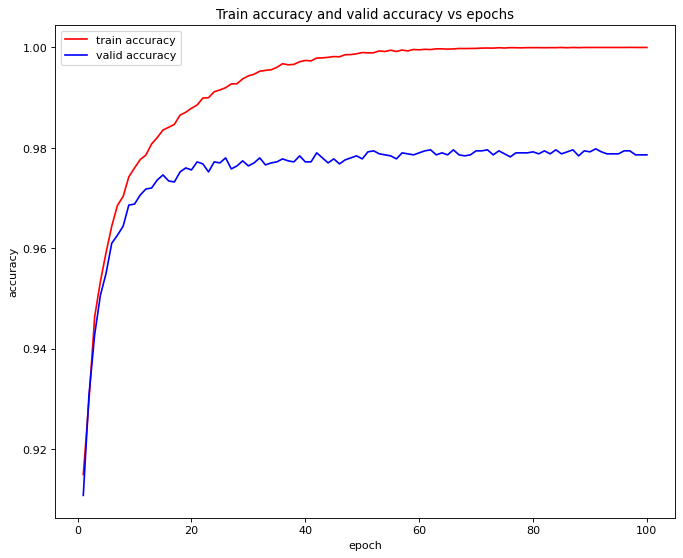

In [15]:
# plot the training and validation accuracies versus epochs

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)

epochs_range = np.arange(1,num_epoch+1)

# plotting
plt.title("Train accuracy and valid accuracy vs epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.plot(epochs_range, train_acc_list, color ="red")
plt.plot(epochs_range, valid_acc_list, color ="blue")
plt.legend(['train accuracy', 'valid accuracy'], loc='best')

# plt.ylim([0.80, 1.10])

plt.show()

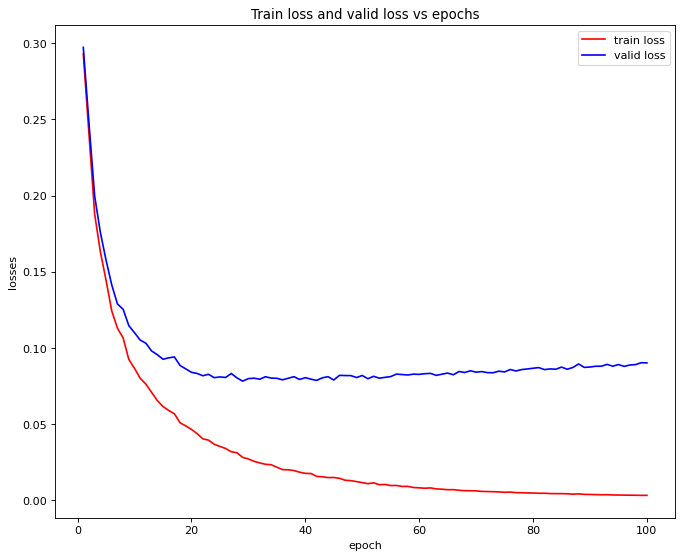

In [16]:
# plot the training and validation losses versus epochs

figure(figsize=(10, 8), dpi=80)

epochs_range = np.arange(1,num_epoch+1)

# plotting
plt.title("Train loss and valid loss vs epochs")
plt.xlabel("epoch")
plt.ylabel("losses")

plt.plot(epochs_range, train_losses, color ="red")
plt.plot(epochs_range, valid_losses, color ="blue")
plt.legend(['train loss', 'valid loss'], loc='best')
plt.show()

# Testing #

In [17]:
y_test_pred = nn.predict(X_test)
test_acc = np.sum(y_test_pred == y_test) / len(y_test)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test accuracy: 97.710%
